In [1]:
import sys
sys.path.append("../src/")
from mixae import mixae_model, entropy_callback, probabilities_log

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import adjusted_rand_score
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%matplotlib inline

In [3]:
(x_full, y_tr), (x_labeled, y_lab) = tf.keras.datasets.mnist.load_data()
x_full = (np.expand_dims(x_full, -1)/255)
x_labeled = np.expand_dims(x_labeled, -1)/255
y_lab_onehot = OneHotEncoder().fit_transform(y_lab.reshape(-1, 1))
n_samples = x_full.shape[0]

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [4]:
n_layers = 3
latent_dim = 8
kernel_architecture = [3,]*n_layers
filter_architecture = [32, 16, 8]
strides_architecture = [2, 2, 2]
pooling_architecture = [0,]*n_layers

mode_config = {
    "simulated_mode":False, #deprecated, to be removed
    "restore_mode":False, #indicates whether to load weights 
    "include_KL":False, #whether to compute the KL loss over the latent space
    "include_MMD":False, #same as above, but MMD 
    "include_KM":False, #same as above, but K-means. See thesis for a more in-depth treatment of these
    "batchnorm":False, #whether to include batch-normalization between layers
    "use_vgg":False, #whether the input data is from a pre-trained model 
    "use_dd":False, #whether to use the dueling-decoder objective 
}

reg_strength = 1e-6
ae_args = [
    [
        n_layers,
        filter_architecture,
        kernel_architecture,
        strides_architecture,
        pooling_architecture,
        latent_dim,
        x_full.shape,
    ],
    {
        "mode_config":mode_config
    },
    [],
    {
        "kernel_reg_strength":reg_strength,
        "kernel_reg": tf.keras.regularizers.l2,
        "output_activation": "sigmoid"
    }
]

x_full_flat = x_full.reshape(n_samples, -1)
x_lab_flat = x_labeled.reshape(x_labeled.shape[0], -1)
print(x_full_flat.max(), x_full_flat.min())

In [5]:
mix_obj = mixae_model(ae_args)
m, mp, clst, _ = mix_obj.compile(10)

pl = probabilities_log(clst, x_lab_flat)
earlystopping = tf.keras.callbacks.EarlyStopping(
    "batch_ent_loss",
    min_delta=0,
    patience=2,
    #restore_best_weights=True,
    baseline=0.1
)
earlystopping_pre = tf.keras.callbacks.EarlyStopping("val_loss", min_delta=1e-2, patience=2)


DECONV SHAPE 3
DECONV SHAPE 3
DECONV SHAPE 3
DECONV SHAPE 3
DECONV SHAPE 3
DECONV SHAPE 3
DECONV SHAPE 3
DECONV SHAPE 3
DECONV SHAPE 3
DECONV SHAPE 3
target (?, ?, ?)
recons (?, ?, ?)
mse_pre_sum (10, ?, 784)
mse reduced (10, ?)
probs  (?, 10)
weighted (?, 10)
clf ent
batch_ent
target (?, ?, ?)
recons (?, ?, ?)
mse_pre_sum (10, ?, 784)
mse reduced (10, ?)
probs  (?, 10)
weighted (?, 10)


In [7]:
def update_wrapper(self, func):
    def func_wrapper(epoch, logs={}):
        print()
        print("old min delta", self.min_delta)
        self.min_delta *= (0.96*2/3)**epoch
        print("New min_delta", self.min_delta)
        return func(epoch, logs)
    return func_wrapper
earlystopping.update_wrapper = update_wrapper
earlystopping.on_epoch_end = earlystopping.update_wrapper(earlystopping, earlystopping.on_epoch_end)

In [9]:
"""
clf_hist = clst.fit(
    x_lab_flat[:1000],
    [y_lab_onehot[:1000]],
    epochs=100,
    batch_size=100,
    callbacks=[earlystopping_pre],
    validation_split=0.2,
)

pretrain_hist = mp.fit(
    x_lab_flat[:1000],
    [np.expand_dims(x_lab_flat[:1000], 1), y_lab_onehot[:1000]],
    epochs=1000,
    batch_size=100,
    callbacks=[earlystopping_pre,],
    validation_split=0.2,
)
"""

'\nclf_hist = clst.fit(\n    x_lab_flat[:1000],\n    [y_lab_onehot[:1000]],\n    epochs=100,\n    batch_size=100,\n    callbacks=[earlystopping_pre],\n    validation_split=0.2,\n)\n\npretrain_hist = mp.fit(\n    x_lab_flat[:1000],\n    [np.expand_dims(x_lab_flat[:1000], 1), y_lab_onehot[:1000]],\n    epochs=1000,\n    batch_size=100,\n    callbacks=[earlystopping_pre,],\n    validation_split=0.2,\n)\n'

In [10]:
"""
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(17, 12))
histories = [clf_hist, pretrain_hist]
models = [clst, mp]
for i in range(2):
    model = models[i]
    hist = histories[i]
    
    perf_labels = model.metrics_names
    for j, label in enumerate(perf_labels):
        axs[i][j].plot(hist.history[label], label=label)
        axs[i][j].legend(loc="best")
plt.tight_layout()
"""

'\nfig, axs = plt.subplots(ncols=4, nrows=2, figsize=(17, 12))\nhistories = [clf_hist, pretrain_hist]\nmodels = [clst, mp]\nfor i in range(2):\n    model = models[i]\n    hist = histories[i]\n    \n    perf_labels = model.metrics_names\n    for j, label in enumerate(perf_labels):\n        axs[i][j].plot(hist.history[label], label=label)\n        axs[i][j].legend(loc="best")\nplt.tight_layout()\n'

[0.10157951 0.0996548  0.10105261 0.10070965 0.10099394 0.0998733
 0.09829685 0.09874884 0.09751231 0.10157819]
0


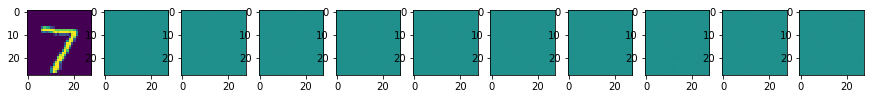

In [11]:
pred = mp.predict_on_batch(x_lab_flat[0:10])
w = 0
which_pred = pred[1][w].argmax()
fig, ax = plt.subplots(ncols=11, figsize=(15, 4))
ax[0].imshow(x_lab_flat[w].reshape(28, 28))
for i in range(10):  
    ax[i+1].imshow(pred[0][w][i].reshape((28, 28)), vmax=1, vmin=0)
print(pred[1][w])
print(which_pred)

In [12]:
#sess = tf.InteractiveSession()
#sess.run(tf.global_variables_initializer())
#tf.keras.backend.set_session(sess)
ep = 0
n_eps = 30

unsuper_hist = m.fit(
    x_full_flat, 
    [
    np.expand_dims(x_full_flat, 1),
    np.zeros(n_samples),
    np.zeros(n_samples)
    ],
    batch_size=50,
    epochs=n_eps,
    initial_epoch=ep,
    callbacks=[
        #entropy_callback(mix_obj.alpha, mix_obj.beta),
        pl,
       # earlystopping,
    ], 
)
ep += n_eps

Epoch 1/30
60000/60000 [==============================] - 95s 2ms/step - loss: 72.8840 - reconstructions_loss: 39.1514 - soft_prob_loss: 1.7330 - batch_ent_loss: 0.3356
Epoch 2/30
60000/60000 [==============================] - 84s 1ms/step - loss: 54.5531 - reconstructions_loss: 21.5397 - soft_prob_loss: 0.2428 - batch_ent_loss: 0.3299
Epoch 3/30
60000/60000 [==============================] - 83s 1ms/step - loss: 50.8887 - reconstructions_loss: 18.1544 - soft_prob_loss: 0.2012 - batch_ent_loss: 0.3271
Epoch 4/30
60000/60000 [==============================] - 82s 1ms/step - loss: 49.1272 - reconstructions_loss: 16.5908 - soft_prob_loss: 0.1804 - batch_ent_loss: 0.3252
Epoch 5/30
60000/60000 [==============================] - 81s 1ms/step - loss: 48.2082 - reconstructions_loss: 15.7420 - soft_prob_loss: 0.1451 - batch_ent_loss: 0.3245
Epoch 6/30
60000/60000 [==============================] - 81s 1ms/step - loss: 47.6315 - reconstructions_loss: 15.1849 - soft_prob_loss: 0.1302 - batch_ent

['loss', 'reconstructions_loss', 'soft_prob_loss', 'batch_ent_loss']


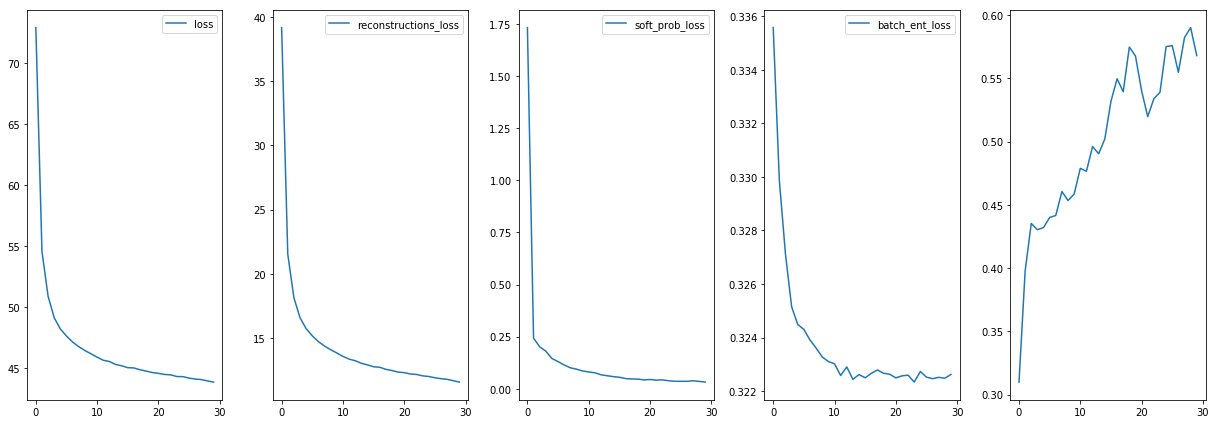

In [13]:
perf_labels = m.metrics_names
print(m.metrics_names)
fig, axs = plt.subplots(ncols=len(perf_labels) + 1, figsize=(17, 6))
for i, label in enumerate(perf_labels):
    axs[i].plot(unsuper_hist.history[label], label=label)
    axs[i].legend(loc="best")

scores = []
for j, pred in enumerate(pl.prob_log):
    clf_pred = pred[1].argmax(1)
    scores.append(adjusted_rand_score(y_lab, clf_pred))
axs[-1].plot(scores)
plt.tight_layout()

(10, 1000, 784)
(1000, 10)
Pred array [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0674816e-33
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.6171235e-31]
Predicted 0
0.9785993 3.219028e-29 0.068966724 0.18329316


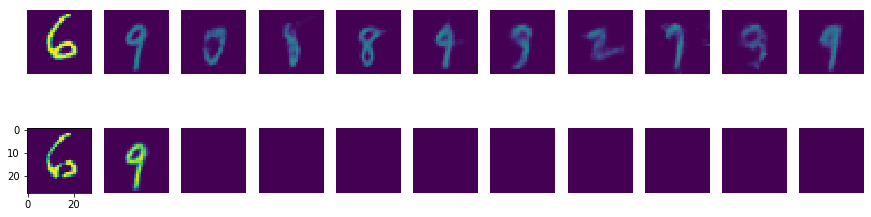

In [25]:
pred = m.predict_on_batch(x_full_flat[0:1000])
#print(pred.shape)
w = 600
print(pred[0].shape)
print(pred[1].shape)
which_pred = pred[1][w].argmax()
fig, ax = plt.subplots(ncols=11, nrows=2, figsize=(15, 4))
ax[0][0].imshow(x_lab_flat[w].reshape(28, 28))
ax[0][0].axis("off")
ax[1][0].imshow(x_lab_flat[w].reshape(28, 28)-pred[0][which_pred][w].reshape((28, 28)), vmax=1, vmin=0)
for i in range(10):  
    ax[0][i+1].imshow(pred[0][i][w].reshape((28, 28)), vmax=2, vmin=0)
    ax[0][i+1].axis("off")
    ax[1][i+1].imshow(pred[1][w][i]*pred[0][i][w].reshape((28, 28)), vmax=1, vmin=0)
    ax[1][i+1].axis("off")
print("Pred array", pred[1][w])
print("Predicted", which_pred)
print(pred[0][:, w].max(), pred[0][:, w].min(), pred[0][:, w].mean(),pred[0][:, w].std())

In [15]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, confusion_matrix
subsamp = 2000
pred_all = m.predict_on_batch(x_full_flat[:subsamp])
pred_class = pred_all[1]

In [16]:
argmaxd = pred_class.argmax(1)
print(adjusted_rand_score(y_tr[:subsamp], argmaxd))
print(confusion_matrix(y_tr[:subsamp], argmaxd))

0.5976211509290906
[[  0 188   1   2   0   0   0   0   0   0]
 [  0   0  36   2   1   5   0 175   0   1]
 [  0   0   1   1   0  45 149   0   0   2]
 [  1   0   0   1   0 124   1   0  62   2]
 [  3   0   0   1 202   0   2   1   0   5]
 [  1   0   1  74   0  51   1   0  52   0]
 [  0   2 174   1  17   0   5   0   1   0]
 [104   0   0   0   1   1   0   4   0 114]
 [  1   0   0 154   0   1   0   0  14   2]
 [128   1   0   0  15   2   0   0   7  57]]


In [17]:
sess = tf.Session()
r = mixae_model.batch_entropy(0, pred[1])
print(sess.run(r))
sess.close()

batch_ent
0.31391257
